In [116]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import scipy.signal

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the model

butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416/chem_annotated.yaml'
# butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml'
gas = ct.Solution(butane_yaml)

In [3]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 5]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 0.5

phi = table7['phi'].values.astype(float)[0]
print(phi)

x_diluent = 0.7771
conc_dict = {
    'O2(2)': 0.207,
    'butane(1)': 0.01595
}


for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

0.5


0.043056902237574995


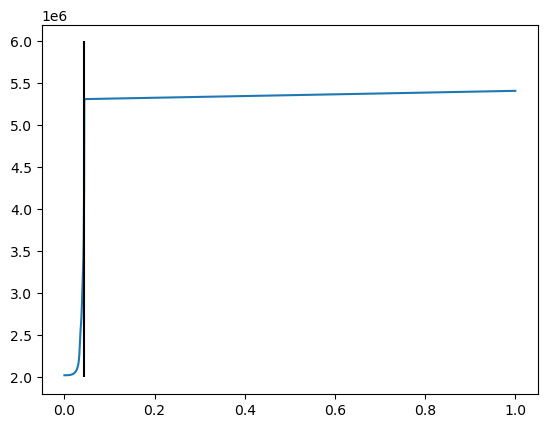

In [109]:
# atols = [1e-15, 1e-15, 1e-18]
# rtols = [1e-9, 1e-12, 1e-15]
gas = ct.Solution(butane_yaml)
t_end = 1.0  # time in seconds
# Ts = [1000]
Ts = [900]
# Ts = [750]
delays = np.zeros(len(Ts))
for j, T in enumerate(Ts):
    P = P7[0]
    X = concentrations[0]
    # function to run a RCM simulation
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    
    reactor_net.atol = 1e-18
    reactor_net.rtol = 1e-15

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    plt.plot(times, P)
    
    threshold = np.percentile(slopes, 80)
    # get 1st time it goes above this threshold
    spike_times = np.argwhere(slopes > threshold)

    
    i = spike_times[0, 0]
#     i = np.argmax(slopes)
    plt.vlines(times[i], 2e6, 6e6, color='black')
    delays[j] = times[i]
    print(times[i])



In [ ]:
# if it's 2-stage ignition, there should be two narrow peaks here

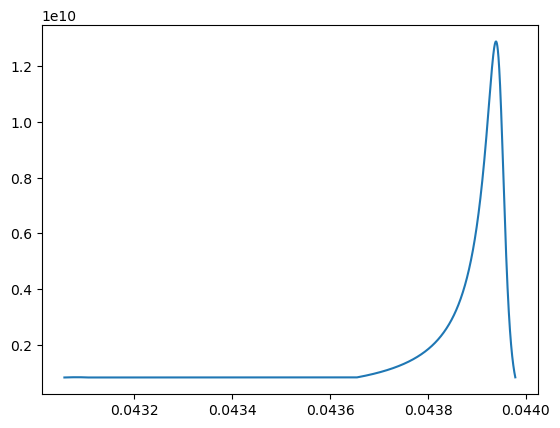

In [115]:
threshold = np.percentile(slopes, 80)
plt.plot(np.array(times)[np.where(slopes > threshold)[0]], slopes[np.where(slopes > threshold)[0]])
ax = plt.gca()
xlim = ax.get_xlim()

In [ ]:

scipy.signal.find_peaks()

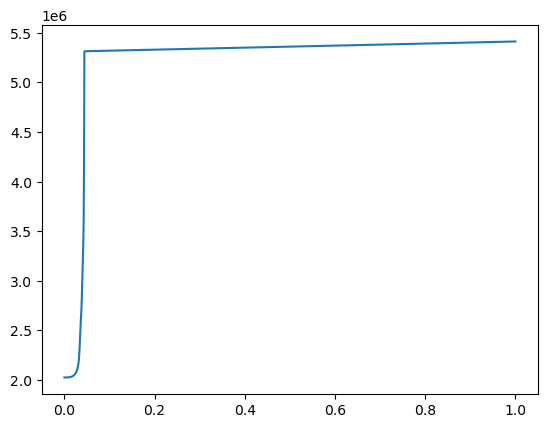

In [114]:
plt.plot(times, P)
# plt.xlim(xlim)

In [66]:
times

[0,
 2.5423828382351967e-15,
 1.5872168934967755e-12,
 6.55115689271776e-12,
 1.1515096891938746e-11,
 1.647903689115973e-11,
 2.1442976890380715e-11,
 3.22992246924199e-11,
 5.6078442757067835e-11,
 7.985766082171577e-11,
 1.036368788863637e-10,
 1.2741609695101165e-10,
 1.7954049405842317e-10,
 2.3166489116583469e-10,
 2.837892882732462e-10,
 3.359136853806577e-10,
 4.1552138486754553e-10,
 4.951290843544334e-10,
 5.747367838413212e-10,
 6.543444833282091e-10,
 7.33952182815097e-10,
 8.135598823019848e-10,
 9.414252415395688e-10,
 1.0692906007771529e-09,
 1.1971559600147369e-09,
 1.3250213192523209e-09,
 1.5188762507196964e-09,
 1.712731182187072e-09,
 1.9065861136544475e-09,
 2.1004410451218233e-09,
 2.294295976589199e-09,
 2.4881509080565748e-09,
 2.6820058395239505e-09,
 2.8758607709913263e-09,
 3.069715702458702e-09,
 3.2635706339260778e-09,
 3.4574255653934535e-09,
 3.6512804968608293e-09,
 3.845135428328205e-09,
 4.137959356321443e-09,
 4.430783284314681e-09,
 4.723607212307918

In [56]:
slopes_sorted = np.sort(slopes)

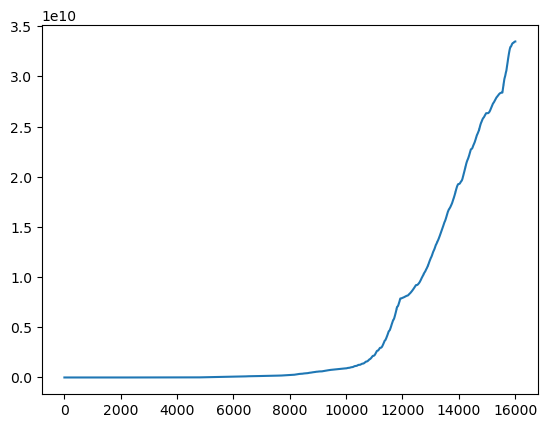

In [57]:
plt.plot(slopes_sorted)

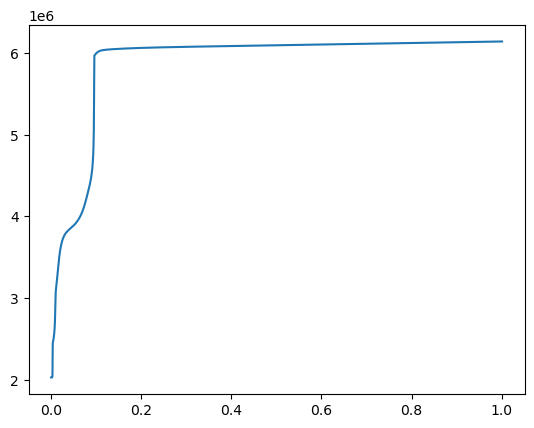

In [18]:
plt.plot(times, P)

In [50]:
slopes = np.gradient(P, times)
slopes_sorted = np.sort(slopes)

threshold = np.percentile(slopes, 95)
# get 1st time it goes above this threshold
spike_times = np.argwhere(slopes > threshold)

# print(spike_times)

print(times[spike_times[0, 0]])

0.0032163497773372756


In [43]:
slopes_sorted[-10:]

array([2.13383515e+09, 2.13383525e+09, 2.13383525e+09, 2.13383534e+09,
       2.13383539e+09, 2.13383544e+09, 2.13383548e+09, 2.13383551e+09,
       2.13383553e+09, 2.13383554e+09])

In [37]:
len(np.gradient(P, times))

36304

In [ ]:
plt.plot(times, slopes)

In [45]:
# get the 95th percentile slope value:
np.percentile(slopes, 95)


1816880847.1164062

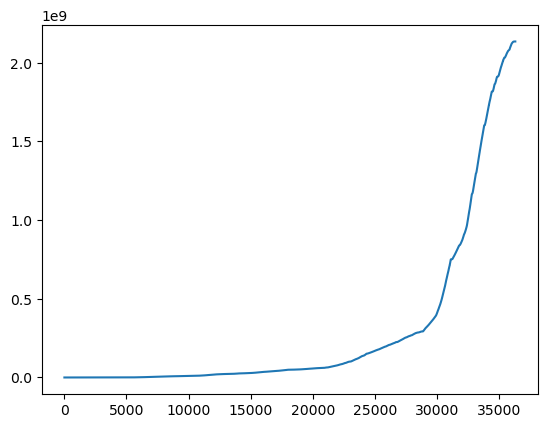

In [44]:
plt.plot(slopes_sorted)

In [ ]:
# Look at distribution of top 10 slopes




(array([26381.,  3702.,   725.,  1119.,   696.,   470.,   470.,   560.,
          853.,  1328.]),
 array([-3.65000000e+01,  2.13383521e+08,  4.26767079e+08,  6.40150637e+08,
         8.53534195e+08,  1.06691775e+09,  1.28030131e+09,  1.49368487e+09,
         1.70706843e+09,  1.92045198e+09,  2.13383554e+09]),
 <BarContainer object of 10 artists>)

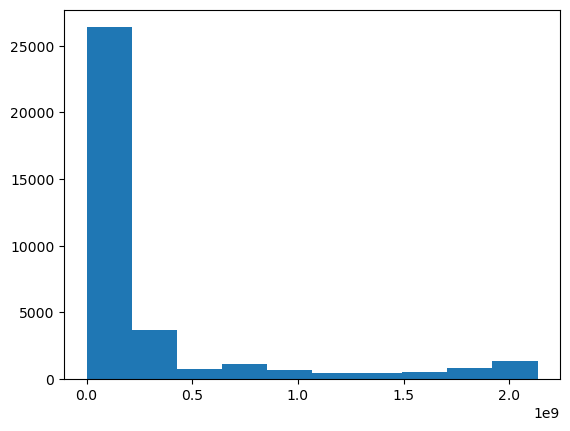

In [21]:
plt.hist(slopes)

In [15]:
Ts

[732, 733]

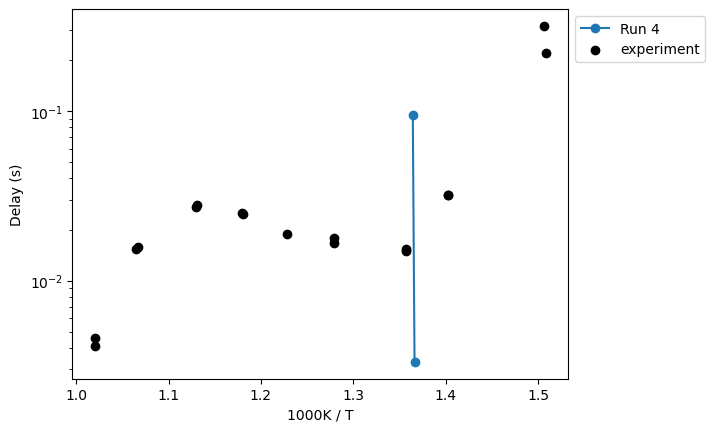

In [16]:
# plot the ignition delay
plt.plot(1000.0 / np.array(Ts), delays, marker='o', label='Run 4')

# plt.plot(1000.0 / temperatures, base_delays, marker='o', label='Run 4 base')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
# plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.legend(bbox_to_anchor=(1, 1))